https://towardsdatascience.com/double-deep-q-networks-905dd8325412

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import numpy as np
import gym
import random
from collections import deque

In [2]:
class BasicBuffer:

  def __init__(self, max_size):
      self.max_size = max_size
      self.buffer = deque(maxlen=max_size)

  def push(self, state, action, reward, next_state, done):
      experience = (state, action, np.array([reward]), next_state, done)
      self.buffer.append(experience)

  def sample(self, batch_size):
      state_batch = []
      action_batch = []
      reward_batch = []
      next_state_batch = []
      done_batch = []

      batch = random.sample(self.buffer, batch_size)

      for experience in batch:
          state, action, reward, next_state, done = experience
          state_batch.append(state)
          action_batch.append(action)
          reward_batch.append(reward)
          next_state_batch.append(next_state)
          done_batch.append(done)

      return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)

  def __len__(self):
      return len(self.buffer)


In [3]:
def mini_batch_train(env, agent, max_episodes, max_steps, batch_size):
    episode_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            episode_reward += reward

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)   

            if done or step == max_steps-1:
                episode_rewards.append(episode_reward)
                print("Episode " + str(episode) + ": " + str(episode_reward))
                break

            state = next_state

    return episode_rewards

In [4]:
class ConvDQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(ConvDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc_input_dim = self.feature_size()
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_dim)
        )

    def forward(self, state):
        features = self.conv_net(state)
        features = features.view(features.size(0), -1)
        qvals = self.fc(features)
        return qvals

    def feature_size(self):
        return self.conv_net(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)


In [5]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim[0], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_dim)
        )

    def forward(self, state):
        qvals = self.fc(state)
        return qvals

In [6]:
class DQNAgent:

    def __init__(self, env, use_conv=True, learning_rate=3e-4, gamma=0.99, tau=0.01, buffer_size=10000):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = BasicBuffer(max_size=buffer_size)
	
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.use_conv = use_conv
        if self.use_conv:
            self.model = ConvDQN(env.observation_space.shape, env.action_space.n).to(self.device)
            self.target_model = ConvDQN(env.observation_space.shape, env.action_space.n).to(self.device)
        else:
            self.model = DQN(env.observation_space.shape, env.action_space.n).to(self.device)
            self.target_model = DQN(env.observation_space.shape, env.action_space.n).to(self.device)
        
        # hard copy model parameters to target model parameters
        for target_param, param in zip(self.model.parameters(), self.target_model.parameters()):
            target_param.data.copy_(param)

        self.optimizer = torch.optim.Adam(self.model.parameters())
        
        
    def get_action(self, state, eps=0.20):
        state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
        qvals = self.model.forward(state)
        action = np.argmax(qvals.cpu().detach().numpy())
        
        if(np.random.randn() < eps):
            return self.env.action_space.sample()

        return action

    def compute_loss(self, batch):     
        states, actions, rewards, next_states, dones = batch
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones)

        # resize tensors
        actions = actions.view(actions.size(0), 1)
        dones = dones.view(dones.size(0), 1)

        # compute loss
        curr_Q = self.model.forward(states).gather(1, actions)
        next_Q = self.target_model.forward(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        max_next_Q = max_next_Q.view(max_next_Q.size(0), 1)
        expected_Q = rewards + (1 - dones) * self.gamma * max_next_Q
        
        loss = F.mse_loss(curr_Q, expected_Q.detach())
        
        return loss

    def update(self, batch_size):
        batch = self.replay_buffer.sample(batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # target network update
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param)


In [7]:
env_id = "CartPole-v0"
MAX_EPISODES = 1000
MAX_STEPS = 500
BATCH_SIZE = 32

In [8]:
env = gym.make(env_id).env

In [9]:
agent = DQNAgent(env, use_conv=False)

In [10]:
episode_rewards = mini_batch_train(env, agent, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: 13.0
Episode 1: 25.0
Episode 2: 17.0
Episode 3: 53.0
Episode 4: 15.0
Episode 5: 12.0
Episode 6: 19.0
Episode 7: 21.0
Episode 8: 16.0
Episode 9: 11.0
Episode 10: 28.0
Episode 11: 18.0
Episode 12: 29.0
Episode 13: 44.0
Episode 14: 62.0
Episode 15: 12.0
Episode 16: 43.0
Episode 17: 29.0
Episode 18: 43.0
Episode 19: 17.0
Episode 20: 30.0
Episode 21: 69.0
Episode 22: 13.0
Episode 23: 36.0
Episode 24: 37.0
Episode 25: 58.0
Episode 26: 104.0
Episode 27: 87.0
Episode 28: 18.0
Episode 29: 72.0
Episode 30: 32.0
Episode 31: 50.0
Episode 32: 100.0
Episode 33: 34.0
Episode 34: 41.0
Episode 35: 62.0
Episode 36: 68.0
Episode 37: 175.0
Episode 38: 71.0
Episode 39: 89.0
Episode 40: 45.0
Episode 41: 52.0
Episode 42: 17.0
Episode 43: 33.0
Episode 44: 128.0
Episode 45: 18.0
Episode 46: 121.0
Episode 47: 114.0
Episode 48: 162.0
Episode 49: 111.0
Episode 50: 43.0
Episode 51: 42.0
Episode 52: 13.0
Episode 53: 42.0
Episode 54: 43.0
Episode 55: 219.0
Episode 56: 34.0
Episode 57: 230.0
Episode 58: 93

Episode 459: 32.0
Episode 460: 60.0
Episode 461: 16.0
Episode 462: 10.0
Episode 463: 20.0
Episode 464: 25.0
Episode 465: 20.0
Episode 466: 14.0
Episode 467: 13.0
Episode 468: 19.0
Episode 469: 115.0
Episode 470: 23.0
Episode 471: 23.0
Episode 472: 29.0
Episode 473: 44.0
Episode 474: 102.0
Episode 475: 12.0
Episode 476: 12.0
Episode 477: 67.0
Episode 478: 17.0
Episode 479: 48.0
Episode 480: 115.0
Episode 481: 13.0
Episode 482: 135.0
Episode 483: 90.0
Episode 484: 14.0
Episode 485: 17.0
Episode 486: 27.0
Episode 487: 91.0
Episode 488: 13.0
Episode 489: 33.0
Episode 490: 52.0
Episode 491: 12.0
Episode 492: 20.0
Episode 493: 124.0
Episode 494: 19.0
Episode 495: 16.0
Episode 496: 44.0
Episode 497: 131.0
Episode 498: 16.0
Episode 499: 114.0
Episode 500: 118.0
Episode 501: 18.0
Episode 502: 30.0
Episode 503: 116.0
Episode 504: 25.0
Episode 505: 34.0
Episode 506: 33.0
Episode 507: 16.0
Episode 508: 17.0
Episode 509: 23.0
Episode 510: 26.0
Episode 511: 17.0
Episode 512: 15.0
Episode 513: 22.0
E

Episode 913: 51.0
Episode 914: 18.0
Episode 915: 13.0
Episode 916: 31.0
Episode 917: 22.0
Episode 918: 17.0
Episode 919: 46.0
Episode 920: 20.0
Episode 921: 10.0
Episode 922: 8.0
Episode 923: 19.0
Episode 924: 19.0
Episode 925: 16.0
Episode 926: 13.0
Episode 927: 25.0
Episode 928: 17.0
Episode 929: 15.0
Episode 930: 68.0
Episode 931: 16.0
Episode 932: 67.0
Episode 933: 14.0
Episode 934: 16.0
Episode 935: 9.0
Episode 936: 19.0
Episode 937: 102.0
Episode 938: 21.0
Episode 939: 44.0
Episode 940: 28.0
Episode 941: 15.0
Episode 942: 48.0
Episode 943: 19.0
Episode 944: 21.0
Episode 945: 25.0
Episode 946: 14.0
Episode 947: 17.0
Episode 948: 12.0
Episode 949: 13.0
Episode 950: 23.0
Episode 951: 62.0
Episode 952: 12.0
Episode 953: 9.0
Episode 954: 39.0
Episode 955: 182.0
Episode 956: 140.0
Episode 957: 37.0
Episode 958: 20.0
Episode 959: 14.0
Episode 960: 13.0
Episode 961: 11.0
Episode 962: 18.0
Episode 963: 59.0
Episode 964: 14.0
Episode 965: 15.0
Episode 966: 21.0
Episode 967: 15.0
Episode 96

In [12]:
import matplotlib.pyplot as plt

In [16]:
plt.figure(figsize=(12,10))

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

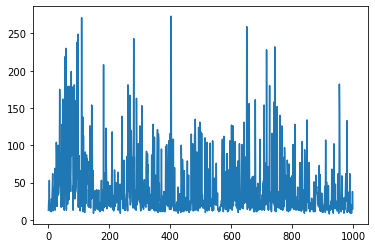

In [19]:
plt.plot(episode_rewards)